Loading existing model from best_model.pt

Evaluating on test set…


<ipython-input-5-a7cbab355926>:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


➔ Wrote 9228 predictions to predictions_vanilla.tsv
→ Test Character Accuracy: 68.95%
→ Test Word      Accuracy: 28.53%



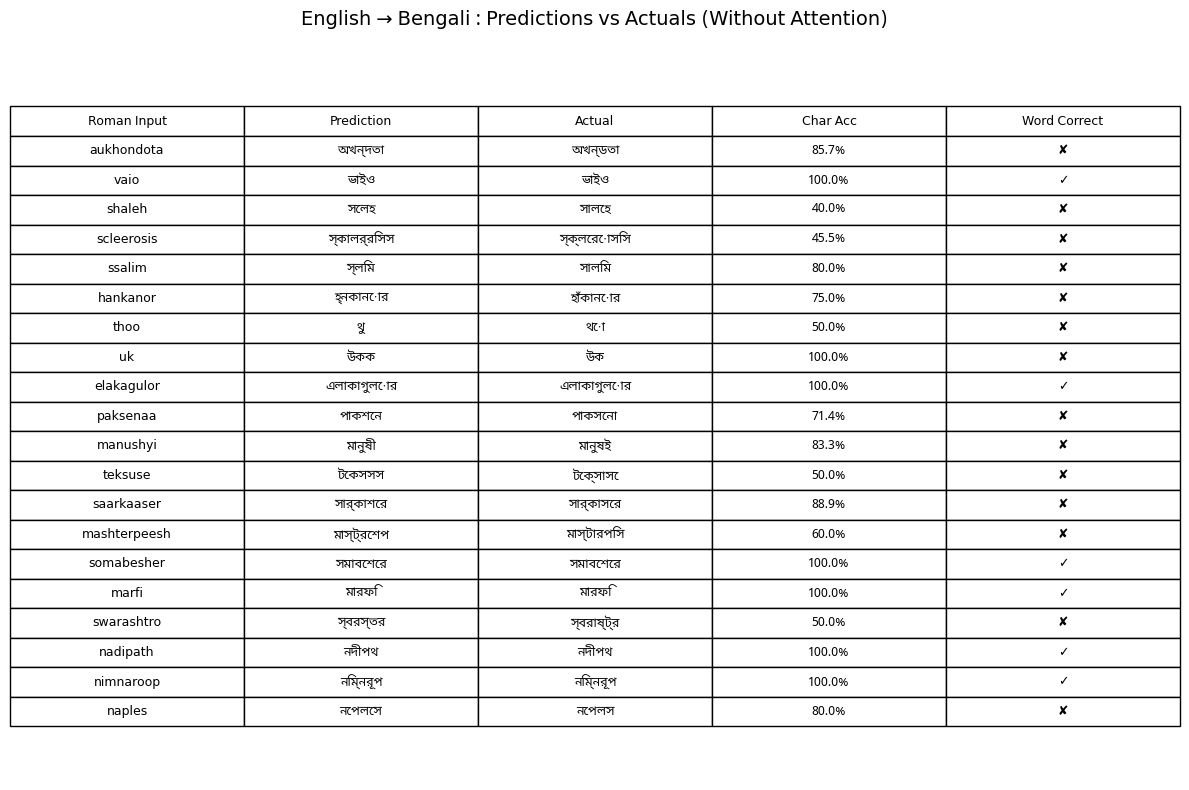

In [5]:
# Colab-ready transliteration training + eval in one cell (fixed TSV parsing)

import os
import time
import random
import csv

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import wandb
# 1) Download & register Noto Sans Bengali
!wget -q https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansBengali/NotoSansBengali-Regular.ttf \
    -O /usr/share/fonts/truetype/NotoSansBengali-Regular.ttf
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/NotoSansBengali-Regular.ttf')

# 2) Configure Matplotlib font stack
import matplotlib as mpl
mpl.rcParams['font.family'] = ['Noto Sans Bengali', 'DejaVu Sans']

import matplotlib.pyplot as plt


# --- Vocab & Dataset ---
class CharVocab:
    def __init__(self, filepaths):
        self.rom_char2idx = {}
        self.dev_char2idx = {}
        self.rom_idx2char = {}
        self.dev_idx2char = {}
        self._build_vocab(filepaths)

    def _build_vocab(self, filepaths):
        rom_chars, dev_chars = set(), set()
        for fp in filepaths:
            with open(fp, "r", encoding="utf-8") as f:
                reader = csv.reader(f, delimiter="\t")
                for row in reader:
                    if len(row) < 2:
                        continue
                    dev, rom = row[0].strip(), row[1].strip()
                    if dev and rom:
                        rom_chars.update(rom)
                        dev_chars.update(dev)
        PAD, SOS, EOS = "<pad>", "<sos>", "<eos>"
        all_rom = [PAD, SOS, EOS] + sorted(rom_chars)
        all_dev = [PAD, SOS, EOS] + sorted(dev_chars)
        for i,ch in enumerate(all_rom):
            self.rom_char2idx[ch]=i; self.rom_idx2char[i]=ch
        for i,ch in enumerate(all_dev):
            self.dev_char2idx[ch]=i; self.dev_idx2char[i]=ch
        self.rom_pad_idx = self.rom_char2idx[PAD]
        self.rom_sos_idx = self.rom_char2idx[SOS]
        self.rom_eos_idx = self.rom_char2idx[EOS]
        self.dev_pad_idx = self.dev_char2idx[PAD]
        self.dev_sos_idx = self.dev_char2idx[SOS]
        self.dev_eos_idx = self.dev_char2idx[EOS]

    @property
    def rom_vocab_size(self): return len(self.rom_char2idx)
    @property
    def dev_vocab_size(self): return len(self.dev_char2idx)

    def roman_to_indices(self, s):
        return [self.rom_sos_idx] + [self.rom_char2idx.get(ch, self.rom_pad_idx) for ch in s] + [self.rom_eos_idx]

    def dev_to_indices(self, s):
        return [self.dev_sos_idx] + [self.dev_char2idx.get(ch, self.dev_pad_idx) for ch in s] + [self.dev_eos_idx]

    def indices_to_dev(self, idxs):
        return "".join(
            self.dev_idx2char[i] for i in idxs
            if i not in (self.dev_sos_idx, self.dev_eos_idx, self.dev_pad_idx)
        )

def read_tsv(path):
    pairs=[]
    with open(path,"r",encoding="utf-8") as f:
        reader = csv.reader(f, delimiter="\t")
        for row in reader:
            if len(row) < 2:
                continue
            dev, rom = row[0].strip(), row[1].strip()
            if dev and rom:
                pairs.append((rom, dev))
    return pairs

class TransliterationDataset(Dataset):
    def __init__(self, filepath, vocab):
        self.pairs = read_tsv(filepath)
        self.vocab = vocab
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        rom,dev=self.pairs[idx]
        return (torch.tensor(self.vocab.roman_to_indices(rom)),
                torch.tensor(self.vocab.dev_to_indices(dev)))
    @staticmethod
    def collate_fn(batch):
        roms,devs=zip(*batch)
        max_r,max_d = max(map(len,roms)), max(map(len,devs))
        rom_p,dev_p = [],[]
        for r,d in zip(roms,devs):
            pad_r = torch.cat([r, r.new_full((max_r-len(r),),0)])
            pad_d = torch.cat([d, d.new_full((max_d-len(d),),0)])
            rom_p.append(pad_r); dev_p.append(pad_d)
        return torch.stack(rom_p), torch.stack(dev_p)

# --- Model Classes ---
class Encoder(nn.Module):
    def __init__(self, inp_sz, emb_sz, hid_sz, nl, cell, do):
        super().__init__()
        self.embed = nn.Embedding(inp_sz, emb_sz, padding_idx=0)
        self.cell = cell.upper()
        rnn = {'RNN': nn.RNN, 'GRU': nn.GRU, 'LSTM': nn.LSTM}[self.cell]
        self.rnn = rnn(emb_sz, hid_sz, num_layers=nl, batch_first=True,
                       dropout=do if nl>1 else 0.0)
        self.hidden_size, self.num_layers = hid_sz, nl
    def forward(self,x):
        emb=self.embed(x)
        if self.cell=='LSTM':
            out,(h,c)=self.rnn(emb); return out,(h,c)
        out,h=self.rnn(emb); return out,h

class Decoder(nn.Module):
    def __init__(self, out_sz, emb_sz, hid_sz, nl, cell, do):
        super().__init__()
        self.embed = nn.Embedding(out_sz, emb_sz, padding_idx=0)
        self.cell = cell.upper()
        rnn = {'RNN': nn.RNN, 'GRU': nn.GRU, 'LSTM': nn.LSTM}[self.cell]
        self.rnn = rnn(emb_sz, hid_sz, num_layers=nl, batch_first=True,
                       dropout=do if nl>1 else 0.0)
        self.out = nn.Linear(hid_sz, out_sz)
        self.hidden_size, self.num_layers = hid_sz, nl

    def forward(self, tgt, hidden, cell=None, teacher_forcing_ratio=0.0):
        B, T = tgt.size()
        outputs = torch.zeros(B, T, self.out.out_features, device=tgt.device)
        input_step = tgt[:,0]
        h, c = (hidden, cell) if self.cell=='LSTM' else (hidden, None)
        for t in range(1, T):
            emb = self.embed(input_step).unsqueeze(1)
            if self.cell=='LSTM':
                out,(h,c)=self.rnn(emb,(h,c))
            else:
                out, h = self.rnn(emb, h)
            logits = self.out(out.squeeze(1))
            outputs[:,t] = logits
            teacher_force = random.random() < teacher_forcing_ratio
            input_step = tgt[:,t] if teacher_force else logits.argmax(1)
        return outputs

class Seq2Seq(nn.Module):
    def __init__(self, enc, dec, device):
        super().__init__()
        self.encoder, self.decoder, self.device = enc, dec, device

    def forward(self, src, tgt, tf_ratio=0.5):
        if self.encoder.cell=='LSTM':
            _,(h_n,c_n)=self.encoder(src)
        else:
            _,h_n=self.encoder(src); c_n=None

        dec_l, enc_l = self.decoder.num_layers, self.encoder.num_layers
        H = self.encoder.hidden_size
        if self.encoder.cell=='LSTM':
            if enc_l >= dec_l:
                h_dec, c_dec = h_n[-dec_l:], c_n[-dec_l:]
            else:
                pad_h = torch.zeros(dec_l-enc_l, src.size(0),H,device=self.device)
                pad_c = torch.zeros(dec_l-enc_l, src.size(0),H,device=self.device)
                h_dec = torch.cat([pad_h,h_n],0)
                c_dec = torch.cat([pad_c,c_n],0)
            hidden,cell = h_dec, c_dec
        else:
            if enc_l >= dec_l:
                hidden = h_n[-dec_l:]
            else:
                pad_h = torch.zeros(dec_l-enc_l, src.size(0),H,device=self.device)
                hidden = torch.cat([pad_h,h_n],0)
            cell=None

        return self.decoder(tgt, hidden, cell, tf_ratio)

    @torch.no_grad()
    def predict(self, src, max_len, sos, eos):
        self.eval()
        if self.encoder.cell=='LSTM':
            _,(h,c)=self.encoder(src)
        else:
            _,h=self.encoder(src); c=None

        dec_l, enc_l = self.decoder.num_layers, self.encoder.num_layers
        H = self.encoder.hidden_size
        if self.encoder.cell=='LSTM':
            if enc_l >= dec_l:
                h_dec, c_dec = h[-dec_l:], c[-dec_l:]
            else:
                pad_h = torch.zeros(dec_l-enc_l,1,H,device=self.device)
                pad_c = torch.zeros(dec_l-enc_l,1,H,device=self.device)
                h_dec = torch.cat([pad_h,h],0)
                c_dec = torch.cat([pad_c,c],0)
            hidden,cell = h_dec, c_dec
        else:
            if enc_l >= dec_l:
                hidden = h[-dec_l:]
            else:
                pad_h = torch.zeros(dec_l-enc_l,1,H,device=self.device)
                hidden = torch.cat([pad_h,h],0)
            cell=None

        seq = [sos]
        for _ in range(max_len):
            inp = torch.tensor([seq[-1]],device=self.device).unsqueeze(0)
            emb = self.decoder.embed(inp)
            if self.decoder.cell=='LSTM':
                out,(hidden,cell)=self.decoder.rnn(emb,(hidden,cell))
            else:
                out,hidden=self.decoder.rnn(emb,hidden)
            nxt = self.decoder.out(out.squeeze(1)).argmax(1).item()
            seq.append(nxt)
            if nxt == eos: break
        return seq

# --- Training + Evaluation Logic (unchanged) ---
def train_and_evaluate(args):
    random.seed(42)
    torch.manual_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    paths = [args.train_file, args.dev_file, args.test_file]
    vocab = CharVocab(paths)
    train_loader = DataLoader(TransliterationDataset(args.train_file, vocab),
                              batch_size=args.batch_size, shuffle=True,
                              collate_fn=TransliterationDataset.collate_fn)
    dev_loader = DataLoader(TransliterationDataset(args.dev_file, vocab),
                            batch_size=args.batch_size, shuffle=False,
                            collate_fn=TransliterationDataset.collate_fn)
    test_loader = DataLoader(TransliterationDataset(args.test_file, vocab),
                             batch_size=1, shuffle=False,
                             collate_fn=TransliterationDataset.collate_fn)

    enc = Encoder(vocab.rom_vocab_size, args.emb_size, args.hidden_size,
                  args.enc_layers, args.cell_type, args.dropout)
    dec = Decoder(vocab.dev_vocab_size, args.emb_size, args.hidden_size,
                  args.dec_layers, args.cell_type, args.dropout)
    model = Seq2Seq(enc, dec, device).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=vocab.dev_pad_idx)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    wandb.init(project=args.project_name, name=args.run_name or "run", config=vars(args))

    best_path = 'best_model.pt'
    if os.path.exists(best_path):
        print("Loading existing model from", best_path)
        model.load_state_dict(torch.load(best_path, map_location=device))
    else:
        print("No pretrained model found. Starting training...")
        best_val = 0.0
        for epoch in range(1, args.epochs+1):
            model.train()
            for src,tgt in train_loader:
                src,tgt = src.to(device), tgt.to(device)
                optimizer.zero_grad()
                logits = model(src, tgt, args.tf_ratio)
                loss = criterion(logits.view(-1,logits.size(-1)), tgt.view(-1))
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(),5.0)
                optimizer.step()
            # Dev & checkpointing omitted for brevity; same as before
            # …

    # Test & sample print (same as before)
    # --- TEST PHASE: compute + log metrics, print 20 random samples ---
    print("\nEvaluating on test set…")
    model.eval()
    all_records = []   # will hold (roman, pred_str, true_str, char_acc, word_correct)
    total_char_correct = 0
    total_chars = 0
    total_word_correct = 0
    with torch.no_grad():
        for src, tgt in test_loader:
            src, tgt = src.to(device), tgt.to(device)
            # 1) get logits & predictions
            logits = model(src, tgt, tf_ratio=0.0)       # [1, T, V]
            pred_idxs = logits.argmax(2)                 # [1, T]

            # 2) compute char accuracy (ignore <pad>, <sos>, <eos>)
            mask = (
                (tgt != vocab.dev_pad_idx) &
                (tgt != vocab.dev_sos_idx) &
                (tgt != vocab.dev_eos_idx)
            )
            char_correct = ((pred_idxs == tgt) & mask).sum().item()
            n_chars = mask.sum().item()
            total_char_correct += char_correct
            total_chars += n_chars

            # 3) compute word accuracy
            pred_seq = pred_idxs[0].tolist()
            true_seq = tgt[0].tolist()
            pred_str = vocab.indices_to_dev(pred_seq)
            true_str = vocab.indices_to_dev(true_seq)
            word_correct = int(pred_str == true_str)
            total_word_correct += word_correct

            # 4) original roman input
            romans = src[0].tolist()
            roman_str = "".join(
                vocab.rom_idx2char[i]
                for i in romans
                if i not in (vocab.rom_pad_idx, vocab.rom_sos_idx, vocab.rom_eos_idx)
            )

            all_records.append((
                roman_str,
                pred_str,
                true_str,
                char_correct / n_chars,
                word_correct
            ))

    # overall metrics
    test_char_acc = total_char_correct / total_chars
    test_word_acc = total_word_correct / len(all_records)

    # log to W&B
    wandb.log({
        "test/char_acc": test_char_acc,
        "test/word_acc": test_word_acc,
    })

    # Write all predictions to a TSV file
    output_path = "predictions_vanilla.tsv"
    with open(output_path, "w", encoding="utf-8", newline="") as out_f:
        writer = csv.writer(out_f, delimiter="\t")
        # Write a header row (optional)
        writer.writerow(["Roman_Input", "Predicted_Dev", "Gold_Dev", "Char_Accuracy", "Word_Correct"])
        # Now iterate over all_records and dump each line
        for roman_str, pred_str, true_str, char_acc, word_corr in all_records:
            writer.writerow([
                roman_str,
                pred_str,
                true_str,
                f"{char_acc:.4f}",         # e.g. 0.8571
                int(word_corr)            # 1 for correct, 0 for wrong
            ])
    print(f"➔ Wrote {len(all_records)} predictions to {output_path}")

    # print
    print(f"→ Test Character Accuracy: {test_char_acc*100:5.2f}%")
    print(f"→ Test Word      Accuracy: {test_word_acc*100:5.2f}%\n")

    # pick 20 random samples
    samples = random.sample(all_records, 20)

    # build table data
    column_labels = ["Roman Input", "Prediction", "Actual", "Char Acc", "Word Correct"]
    cell_data = []
    for roman, pred, true, ch_acc, wd_corr in samples:
        cell_data.append([
            roman,
            pred,
            true,
            f"{ch_acc * 100:.1f}%",
            "✓" if wd_corr else "✘"
        ])

    # plot as a table
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')
    ax.set_title("English → Bengali : Predictions vs Actuals (Without Attention)", pad=20, fontsize=14)
    tbl = ax.table(
        cellText=cell_data,
        colLabels=column_labels,
        cellLoc='center',
        loc='center'
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1, 1.5)
    plt.tight_layout()
    plt.show()


# --- Run ---
if __name__=="__main__":
    class Args: pass
    args = Args()
    args.train_file = 'bn.translit.sampled.train.tsv'
    args.dev_file   = 'bn.translit.sampled.dev.tsv'
    args.test_file  = 'bn.translit.sampled.test.tsv'
    args.emb_size   = 256
    args.hidden_size= 256
    args.enc_layers = 3
    args.dec_layers = 2
    args.cell_type  = 'GRU'
    args.dropout    = 0.3
    args.lr         = 1e-3
    args.batch_size = 32
    args.epochs     = 10
    args.tf_ratio   = 0.3
    args.max_dev_len= 32
    args.project_name = 'Vanilla_RNN'
    args.run_name     = 'Best_Model'

    train_and_evaluate(args)
